# HDBSCAN* Clustering Analysis of SSL-Pretrained Feature Spaces

In this notebook, we use HDBSCAN* to cluster the feature space from a ResNet-18 trained in a self-supervised fashion using the DCLW framework.

## Imports

In [25]:
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
import umap
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from ax.utils.notebook.plotting import render
from PIL import Image
from plotly.subplots import make_subplots
from sklearn.metrics import homogeneity_score

In [2]:
df = pd.read_pickle("../data/interim/model_preds/DCLW_preds_subset.pkl.xz")
data = df.drop(columns=["waferMap", "failureType", "failureCode"]).values

First, we create UMAP and DensMAP embeddings of the feature space to show that SSL leads to well-defined clusters.

In [3]:
# Create a UMAP embedding
reducer = umap.UMAP(random_state=0, verbose=True)
embeddings = reducer.fit_transform(data)
umap_df = pd.DataFrame(embeddings, columns=["umap_x", "umap_y"])

# Create a DensMAP embedding
reducer = umap.UMAP(random_state=0, densmap=True, dens_lambda=1, verbose=True)
dense_embeddings = reducer.fit_transform(data)
densmap_df = pd.DataFrame(dense_embeddings, columns=["densmap_x", "densmap_y"])

# Create a dataframe with the embeddings and the failureType
emb_df = pd.concat([umap_df, densmap_df], axis=1)
emb_df["failureType"] = df.failureType.values

UMAP(random_state=0, verbose=True)
Tue Apr 11 21:07:37 2023 Construct fuzzy simplicial set
Tue Apr 11 21:07:37 2023 Finding Nearest Neighbors
Tue Apr 11 21:07:37 2023 Building RP forest with 11 trees
Tue Apr 11 21:07:37 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Apr 11 21:07:47 2023 Finished Nearest Neighbor Search
Tue Apr 11 21:07:49 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Tue Apr 11 21:07:56 2023 Finished embedding
UMAP(dens_lambda=1, densmap=True, random_state=0, verbose=True)
Tue Apr 11 21:07:56 2023 Construct fuzzy simplicial set
Tue Apr 11 21:07:56 2023 Finding Nearest Neighbors
Tue Apr 11 21:07:56 2023 Building RP forest with 11 trees
Tue Apr 11 21:07:56 2023 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	 4  /  14
	Stopping threshold met -- exiting after 4 iterations
Tue Apr 11 21:07:56 2023 Finished Nearest Neighbor Search
Tue Apr 11 21:07:57 2023 Construct embedding
Tue Apr 11 21:07:58 2023 Computing original densities


Epochs completed:   0%|            0/400 [00:00]

Tue Apr 11 21:08:16 2023 Finished embedding


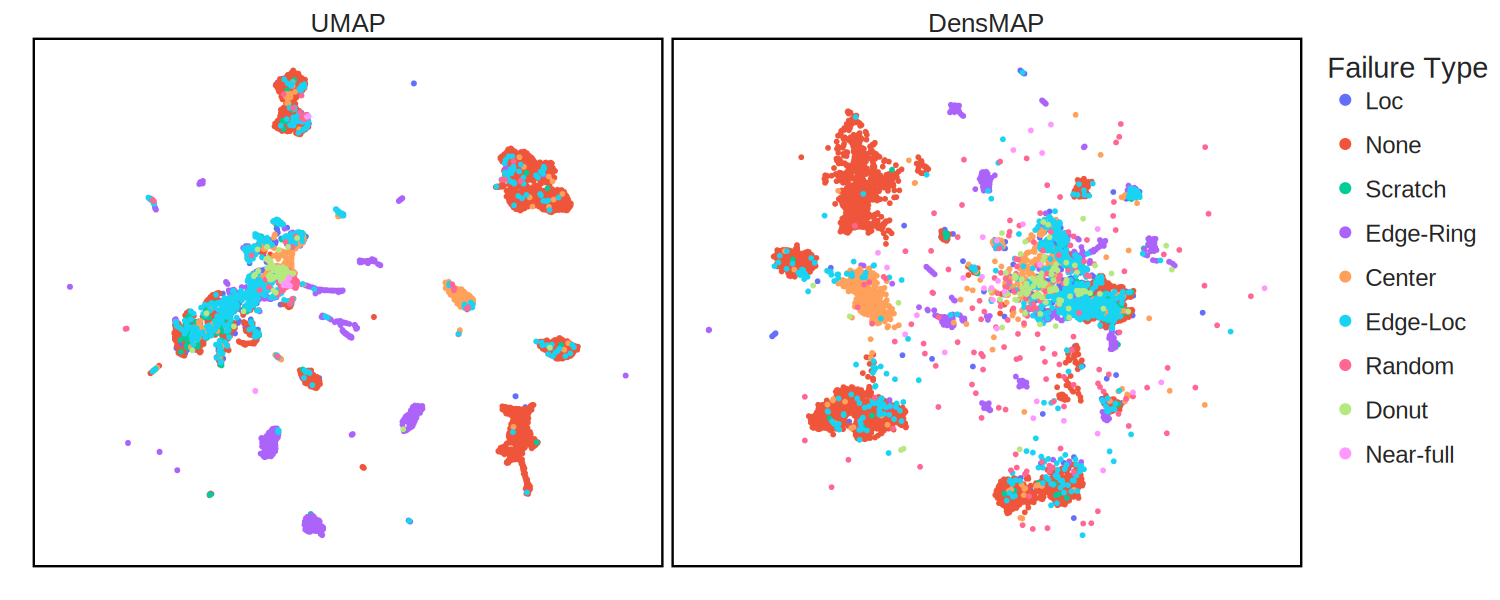

In [4]:
def create_subplots(
    df,
    x_col1,
    y_col1,
    x_col2,
    y_col2,
    color_col,
    subplot_title1,
    subplot_title2,
    legend_title,
    **scatter_kwargs
    # color_discrete_sequence=px.colors.qualitative.Plotly,
):
    # Initialize subplots
    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=(subplot_title1, subplot_title2),
        horizontal_spacing=0.01,
    )

    # Initialize individual figures
    fig1 = px.scatter(
        df,
        x=x_col1,
        y=y_col1,
        color=color_col,
        **scatter_kwargs
    )
    fig2 = px.scatter(
        df,
        x=x_col2,
        y=y_col2,
        color=color_col,
        **scatter_kwargs
    )

    # To prevent the legend from showing up twice, disable it for the second plot
    for trace in fig2.data:
        trace.update(showlegend=False)
    # Now, add the traces to the figure
    for trace1, trace2 in zip(fig1.data, fig2.data):
        fig.add_trace(trace1, row=1, col=1)
        fig.add_trace(trace2, row=1, col=2)
    # Update the layout
    fig.update_layout(
        height=600,
        width=1500,
        legend_title=legend_title,
        margin=dict(r=200, t=40, b=0, l=0),
        legend={"itemsizing": "constant"},
        font=dict(family="Arial", size=24),
        xaxis_title="",
        yaxis_title="",
        template="simple_white",
    )

    # Increase font size of subplot titles
    fig.for_each_annotation(lambda a: a.update(font=dict(family="Arial", size=26)))

    fig.update_xaxes(
        showgrid=False,
        showticklabels=False,
        ticks="",
        zeroline=False,
        showline=True,
        linewidth=2.4,
        linecolor="black",
        mirror="allticks",
    )

    fig.update_yaxes(
        showgrid=False,
        showticklabels=False,
        ticks="",
        zeroline=False,
        showline=True,
        linewidth=2.4,
        linecolor="black",
        mirror="allticks",
    )

    return fig

fig = create_subplots(
    df=emb_df,
    x_col1="umap_x",
    y_col1="umap_y",
    x_col2="densmap_x",
    y_col2="densmap_y",
    color_col="failureType",
    subplot_title1="UMAP",
    subplot_title2="DensMAP",
    legend_title="Failure Type",
)
fig.show("svg")

HDBSCAN* has a lot of hyperparameters that can be tricky to fine-tune. Because we have access to the ground truth labels, we'll set up an optimization experiment that will search through a hyperparameter space using Bayesian optimization. This is framed as a multi-objective problem. We want to have a high homogeneity score and a low number of clusters. The Ax framework makes this easy.

In [235]:
def cluster_and_score(parameterization):
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=parameterization.get("min_cluster_size"),
        min_samples=parameterization.get("min_samples"),
        gen_min_span_tree=True,
        cluster_selection_epsilon=parameterization.get("cluster_selection_epsilon"),
    )
    clusterer.fit(data)
    labels = pd.Series(clusterer.labels_).astype("category").sort_values().values
    score = homogeneity_score(emb_df.failureType.values, labels)
    return {
        "homogeneity": (score, 0.0),
        "n_clusters": (clusterer.labels_.max() + 1, 0.0),
    }


hdbscan_params = [
    {"name": "min_cluster_size", "type": "range", "bounds": [15, 75]},
    {"name": "min_samples", "type": "range", "bounds": [1, 30]},
    {"name": "cluster_selection_epsilon", "type": "range", "bounds": [0.1, 1.5]},
]

# Initialize an AxClient.
ax_client = AxClient(random_seed=42)
ax_client.create_experiment(
    name="cluster_homogeneity",
    parameters=hdbscan_params,
    objectives={
        "homogeneity": ObjectiveProperties(minimize=False),
        "n_clusters": ObjectiveProperties(minimize=True),
    },
    overwrite_existing_experiment=True,
)

# Run 30 trials.
for i in range(30):
    parameters, trial_index = ax_client.get_next_trial()
    ax_client.complete_trial(
        trial_index=trial_index,
        raw_data=cluster_and_score(parameters),
    )

[INFO 04-11 18:11:00] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 04-11 18:11:00] ax.service.ax_client: Random seed set to 42. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 04-11 18:11:00] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 04-11 18:11:00] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter min_cluster_size. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter

Shown below is a pareto plot of the best parameter combinations found through multi-objective Bayesian optimization (there are some issues with Plotly renders saving to file correctly, so this may not show up on your end).

In [249]:
objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["homogeneity", "n_clusters"],
    num_points=50,
)
render(plot_pareto_frontier(frontier, CI_level=0.90), width=800, height=600)

We select one of the best hyperparameter combinations and use it to cluster the feature space. This specific choice doesn't lead to the highest homogeneity score, but it leads to a reasonably low cluster count which is what we're after. We don't want to over-cluster the feature space. Next, the clusters are visualized using UMAP and DensMAP embeddings.

In [4]:
# Chosen from ax_client.get_pareto_optimal_parameters()
best_params = {'min_cluster_size': 75, 'min_samples': 26, 'cluster_selection_epsilon': 1.5}
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=best_params.get("min_cluster_size"),
    min_samples=best_params.get("min_samples"),
    cluster_selection_epsilon=best_params.get("cluster_selection_epsilon"),
    gen_min_span_tree=True,
)
clusterer.fit(data)

# Add the cluster labels to the dataframe
emb_df["best_cluster"] = pd.Series(clusterer.labels_).astype("category").sort_values().values

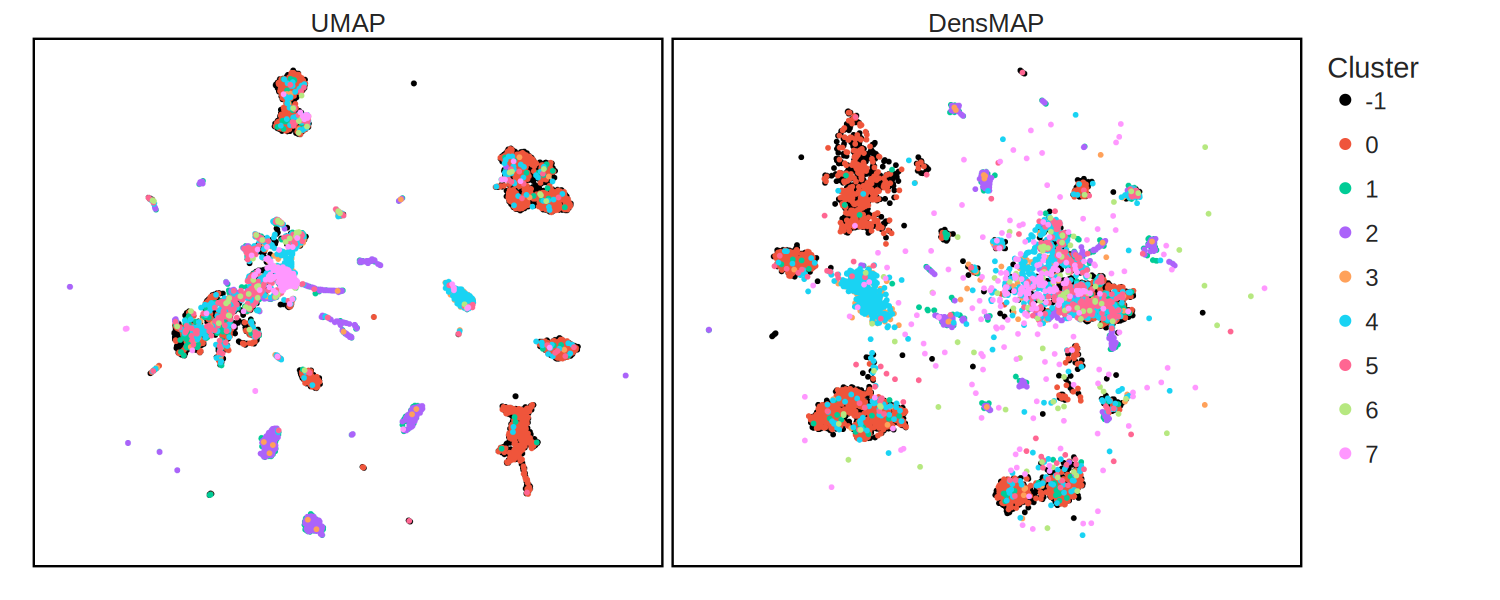

In [6]:
fig = create_subplots(
    df=emb_df.sort_values("best_cluster"),
    x_col1="umap_x",
    y_col1="umap_y",
    x_col2="densmap_x",
    y_col2="densmap_y",
    color_col="best_cluster",
    subplot_title1="UMAP",
    subplot_title2="DensMAP",
    legend_title="Cluster",
    color_discrete_map={
        -1: "black",
    },
)
fig.write_image("../reports/figures/UMAP/best_clustering_1.png", scale=3)
fig.show("svg")

To probe the semantics of these clusters, random query points are selected from each (except for the noise cluster), and the five nearest neighbors are shown. From the UMAP plots and the nearest neighbors, we can see that the clusters are well-defined and semantically meaningful, and they actually align quite well with the ground truth labels.

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



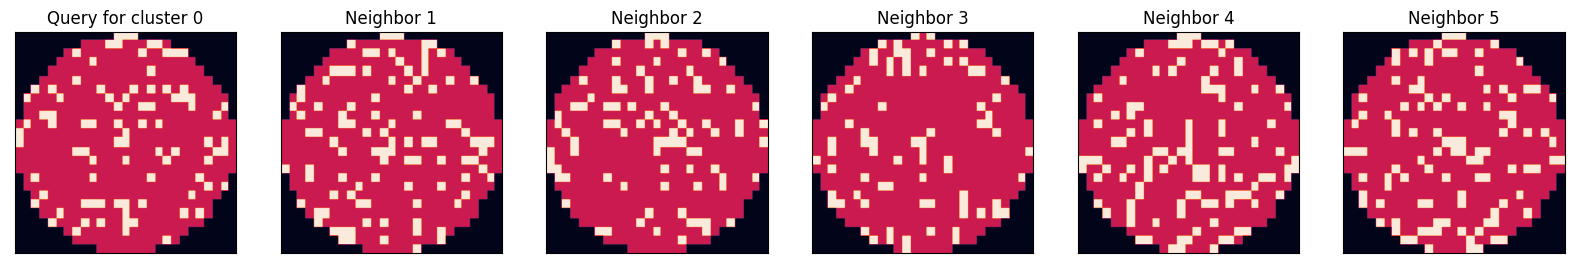

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



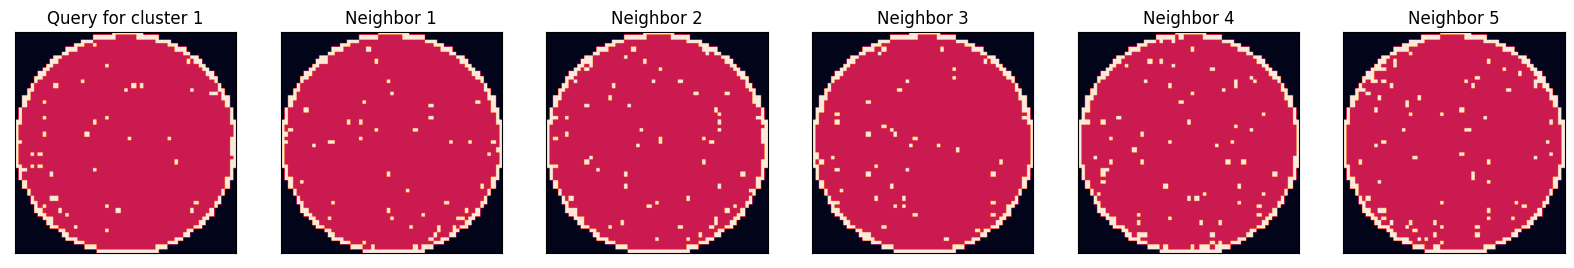

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



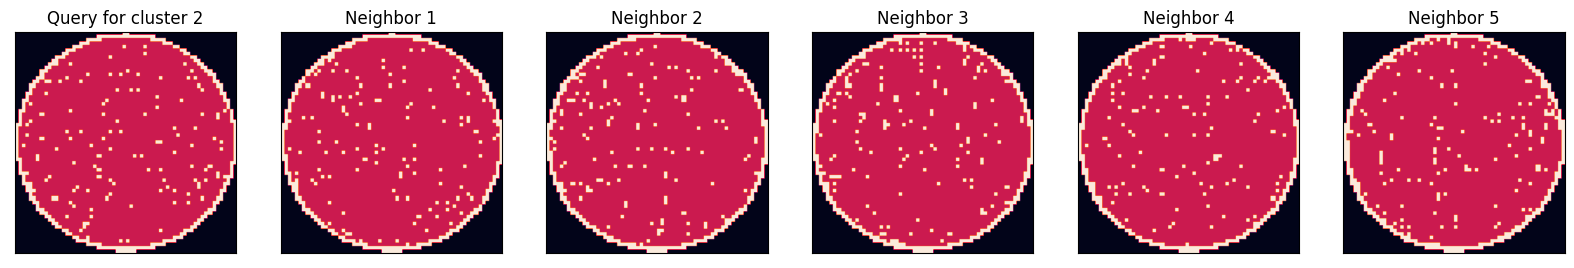

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



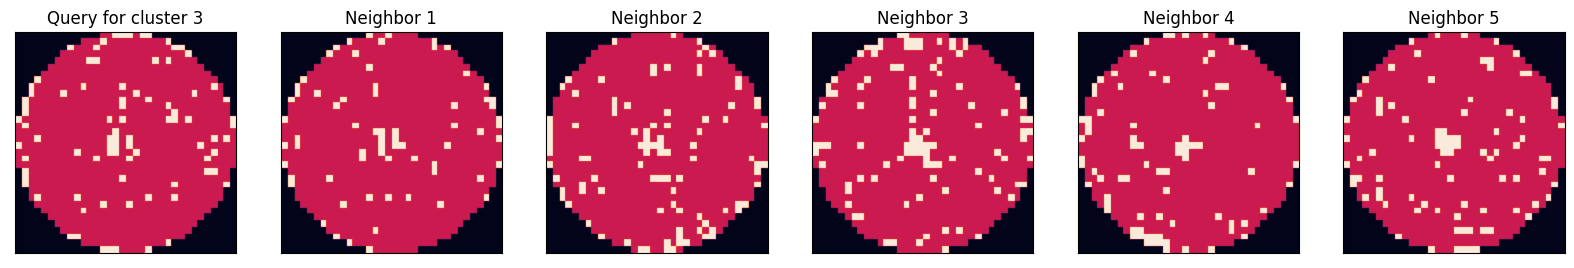

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



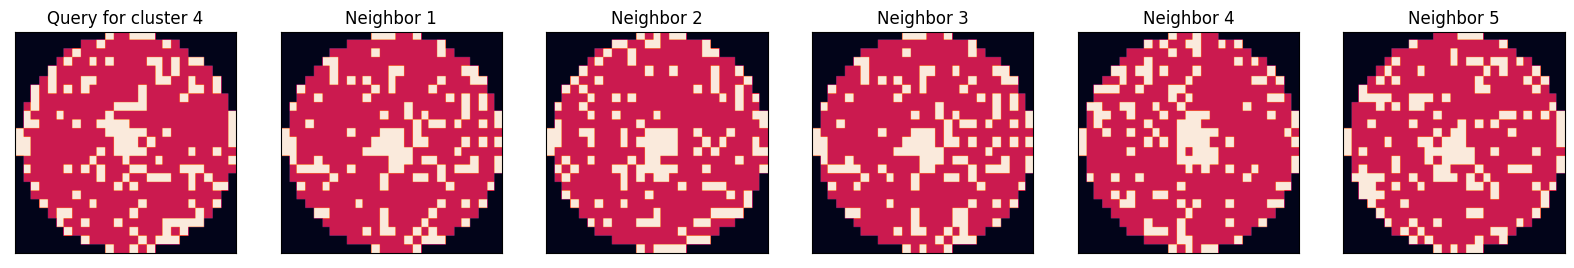

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



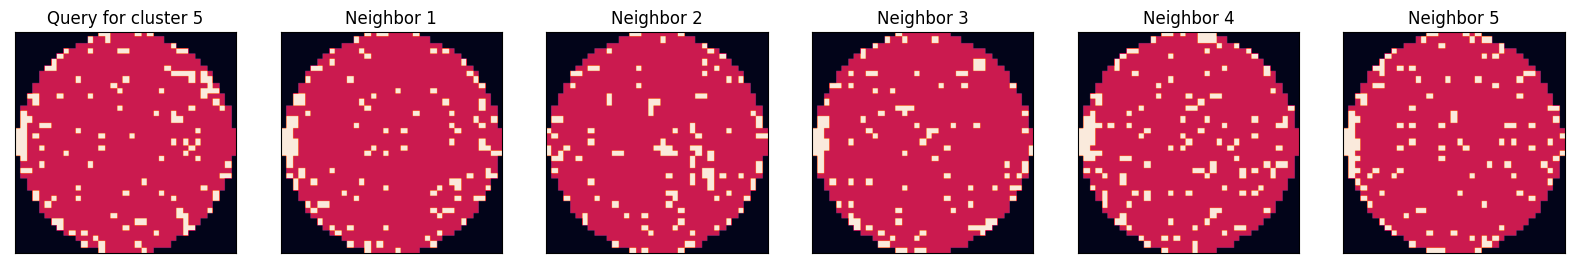

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



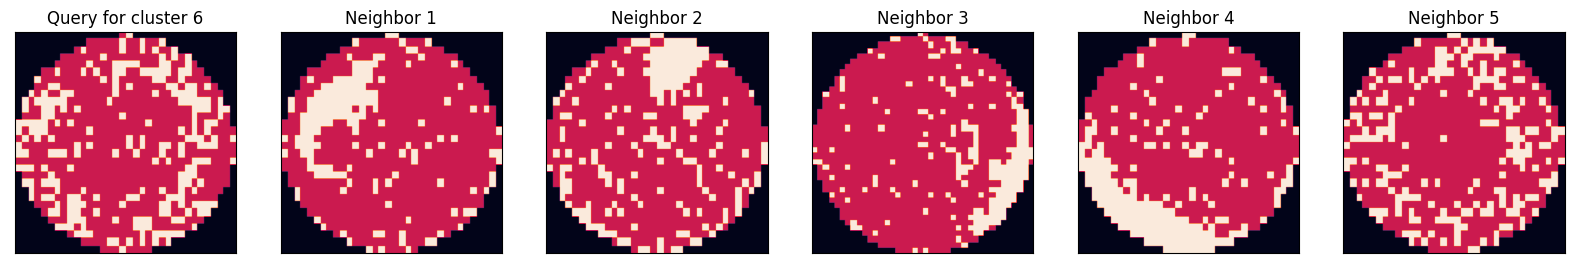

c:\Users\khanm\.conda\envs\ssl-wafermap\lib\site-packages\numpy\linalg\linalg.py:2557: RuntimeWarning:

overflow encountered in reduce



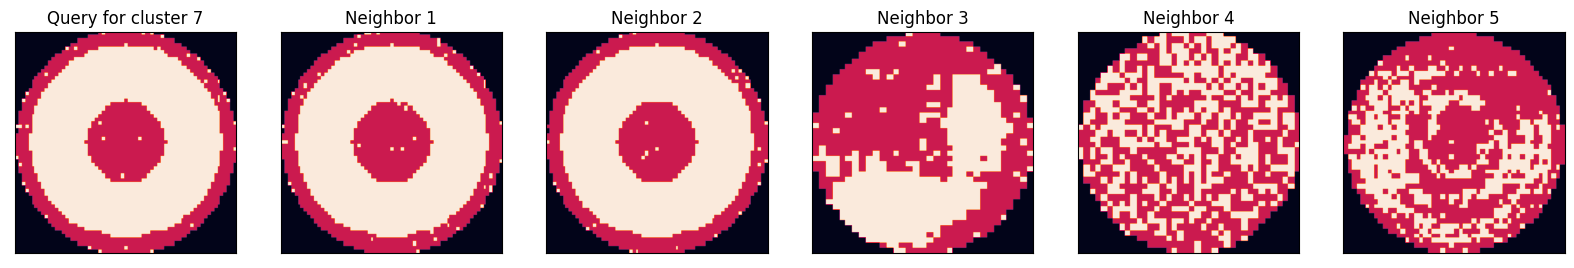

In [49]:
# For a few clusters, select a random point, and plot the nearest neighbors using emb_df.waferMap
# Ignore the -1 cluster, which is the noise cluster
for cluster in emb_df.best_cluster.unique()[1:]:
    # Select a random point from the cluster
    point = emb_df[emb_df.best_cluster == cluster].sample(1)
    point_idx = point.index
    # Find the vector corresponding to this index
    point_vec = data[point_idx]
    # Now, compute the distance between this point and all other points, returning indicies of the top 5
    top_5 = np.argsort(np.linalg.norm(data - point_vec, axis=1))[:6]
    # Get the wafer maps
    wafers = df.iloc[top_5].waferMap.apply(lambda x: Image.fromarray(x).resize((128, 128), Image.Resampling.NEAREST)).values
    # Plot the wafer maps for each using plt.subplots
    # First column should be wafer map for the original point, and the next 5 columns should be the top 5
    fig, axs = plt.subplots(1, 6, figsize=(20, 20))
    axs[0].imshow(wafers[0], cmap="rocket")
    axs[0].set_title(f"Query for cluster {cluster}")
    for i, wafer in enumerate(wafers[1:]):
        axs[i + 1].imshow(wafer, cmap="rocket")
        axs[i + 1].set_title(f"Neighbor {i + 1}")

    # Disable axis labels and ticks
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

Finally, here is the dendrogram hierarchy of the clusters. 

<AxesSubplot:ylabel='$\\lambda$ value'>

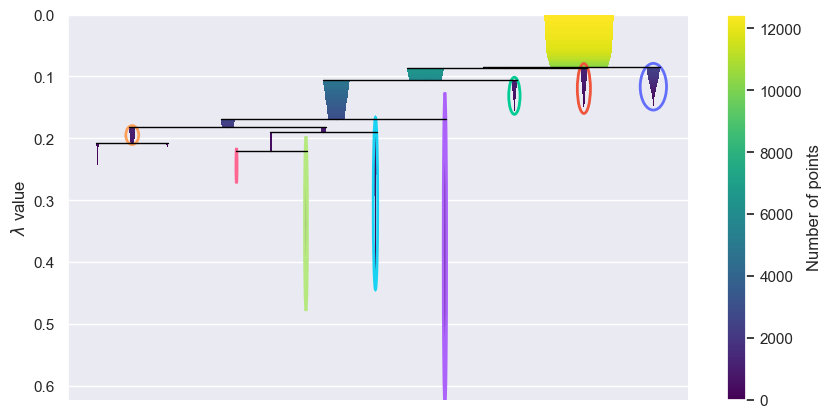

In [294]:
sns.set_theme()

plt.figure(figsize=(10, 5))
clusterer.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=px.colors.qualitative.Plotly
)